In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_json('../Data/combined.json')

In [3]:
df.head()

,DocumentDate,SalePrice,PropertyType,Area,SqFtLot,LakeWashington,LakeSammamish,SmallLakeRiverCreek,WfntLocation,WfntFootage,...,WfntPoorQuality,WfntRestrictedAccess,TidelandShoreland,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
8576000260,1546300800000,583950,2,57.0,5944.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,3270.0,0.0,250.0,3.0
7691000060,1546300800000,539950,2,41.0,8389.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,3200.0,0.0,0.0,3.0
53300380,1546300800000,642950,2,51.0,4000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,2487.0,0.0,45.0,3.0
2525059126,1546300800000,541000,11,91.0,13503.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,1030.0,0.0,210.0,4.0
53300290,1546300800000,647950,2,51.0,5362.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,2487.0,0.0,45.0,3.0


In [4]:
df.SalePrice.mean()

822721.0510429093

In [5]:
# We had enough data that I dropped all the NAN's. Could go back if we decide we want to look at them. about 8K out of the 36K 
df.dropna(inplace=True)

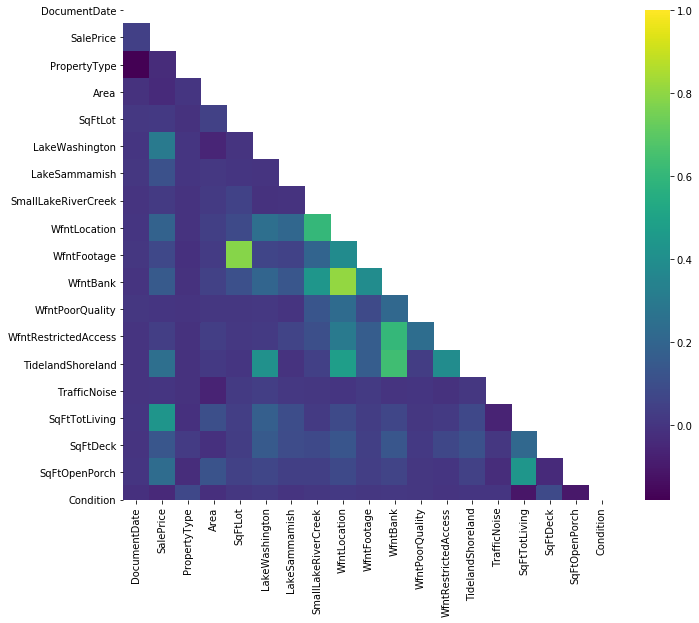

In [6]:
# Heat map comparing the respective columns. Looks like we can take out Airport noise as it has no efffect. 
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

In [7]:
# created a first model dataframe to only inclue SalePrice and sqfttotliving
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()

In [8]:
#First model using SalePrice as target variable and sqFtTotLiving as feature
# real low R-Squared. Doesnt necisarrily mean a bad thing if this is our very first model 
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data=fsm_df)
fsm_results = fsm.fit()

In [9]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     6241.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:20:55   Log-Likelihood:            -4.0281e+05
No. Observations:               26955   AIC:                         8.056e+05
Df Residuals:                   26953   BIC:                         8.056e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.317e+04   1.11e+04      1.185      0.236   -8617.732    3.49e+04
SqFtTotLiving   368.1030      4.659     79.001      0.000     358.970     377.236
==============================================================================
Omnibus:                    51435.931   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        160049261.238
Skew:                          14.671   Prob(JB):                         0.00
Kurtosis:                     379.354   Cond. No.                     5.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
#waterfront dataframe includes SalePrice and LakeWashington

fsm_water_df = df[['SalePrice', 'LakeWashington']].copy()

In [11]:
#Using ordinary least squares, SalePrice as target variable, LakeWashington as ind var
#Rsquared value of 0.085 is quite low

fsm_water = ols(formula="SalePrice~LakeWashington", data=fsm_water_df)
fsm_water_results=fsm_water.fit()

In [12]:
fsm_water_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2653.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:20:58   Log-Likelihood:            -4.0435e+05
No. Observations:               26955   AIC:                         8.087e+05
Df Residuals:                   26953   BIC:                         8.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       7.771e+05   4875.544    159.386      0.000    7.68e+05    7.87e+05
LakeWashington  6.171e+05    1.2e+04     51.507      0.000    5.94e+05    6.41e+05
==============================================================================
Omnibus:                    46741.833   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         91005112.179
Skew:                          11.970   Prob(JB):                         0.00
Kurtosis:                     286.647   Cond. No.                         2.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
df.head()

,DocumentDate,SalePrice,PropertyType,Area,SqFtLot,LakeWashington,LakeSammamish,SmallLakeRiverCreek,WfntLocation,WfntFootage,...,WfntPoorQuality,WfntRestrictedAccess,TidelandShoreland,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
8576000260,1546300800000,583950,2,57.0,5944.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,3270.0,0.0,250.0,3.0
7691000060,1546300800000,539950,2,41.0,8389.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,3200.0,0.0,0.0,3.0
53300380,1546300800000,642950,2,51.0,4000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,2487.0,0.0,45.0,3.0
2525059126,1546300800000,541000,11,91.0,13503.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,1030.0,0.0,210.0,4.0
53300290,1546300800000,647950,2,51.0,5362.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,N,N,2487.0,0.0,45.0,3.0


In [14]:
df.shape

(26955, 21)

In [15]:
column1 = df.iloc[:, 0:7].copy()
column2 = df.iloc[:, 7:14].copy()
column3 = df.iloc[:, 14:21].copy()

In [16]:
column3

,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
8576000260,0.0,N,N,3270.0,0.0,250.0,3.0
7691000060,0.0,N,N,3200.0,0.0,0.0,3.0
53300380,0.0,N,N,2487.0,0.0,45.0,3.0
2525059126,0.0,N,N,1030.0,0.0,210.0,4.0
53300290,0.0,N,N,2487.0,0.0,45.0,3.0
...,...,...,...,...,...,...,...
1426059089,0.0,N,N,3680.0,1000.0,50.0,3.0
7128300190,1.0,N,N,1280.0,0.0,190.0,3.0
3331500845,0.0,N,N,570.0,0.0,0.0,1.0
945000570,0.0,N,Y,2820.0,220.0,0.0,3.0


In [17]:
df.PowerLines.replace(('Y', 'N'), (1, 0), inplace=True)

In [18]:
df.OtherNuisances.replace(('Y', 'N'), (1, 0), inplace=True)

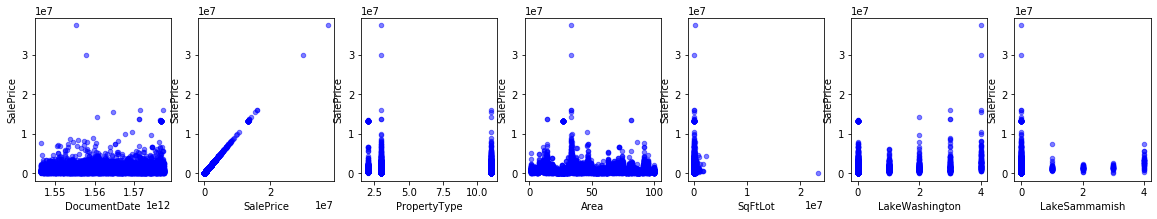

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,3))

for xcol, ax in zip((column1), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

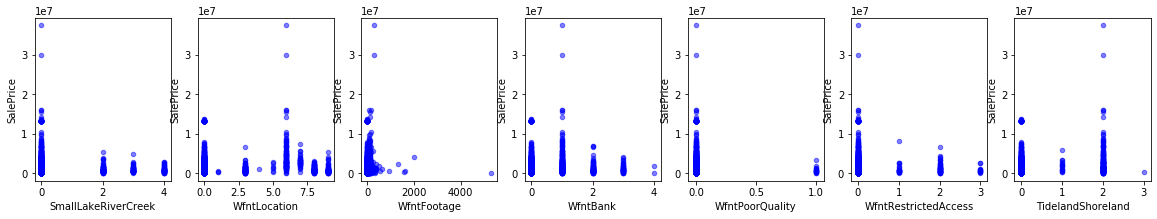

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,3))

for xcol, ax in zip((column2), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

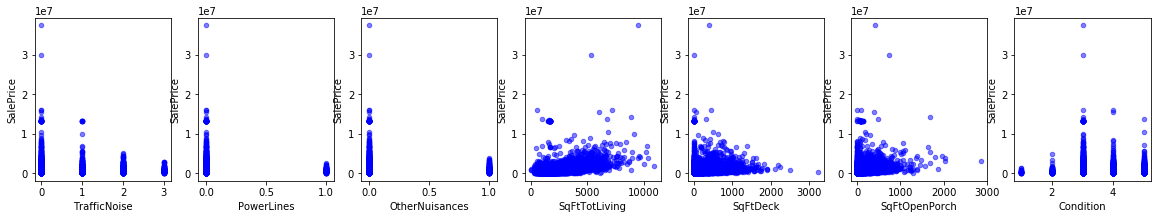

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,3))

for xcol, ax in zip((column3), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

In [22]:
df

,DocumentDate,SalePrice,PropertyType,Area,SqFtLot,LakeWashington,LakeSammamish,SmallLakeRiverCreek,WfntLocation,WfntFootage,...,WfntPoorQuality,WfntRestrictedAccess,TidelandShoreland,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
8576000260,1546300800000,583950,2,57.0,5944.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,3270.0,0.0,250.0,3.0
7691000060,1546300800000,539950,2,41.0,8389.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,3200.0,0.0,0.0,3.0
53300380,1546300800000,642950,2,51.0,4000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,2487.0,0.0,45.0,3.0
2525059126,1546300800000,541000,11,91.0,13503.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1030.0,0.0,210.0,4.0
53300290,1546300800000,647950,2,51.0,5362.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,2487.0,0.0,45.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426059089,1577750400000,1201000,11,36.0,65496.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,3680.0,1000.0,50.0,3.0
7128300190,1577750400000,346629,3,15.0,3000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0,1280.0,0.0,190.0,3.0
3331500845,1577750400000,225000,11,81.0,5150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,570.0,0.0,0.0,1.0
945000570,1577750400000,1150000,11,6.0,4650.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,2820.0,220.0,0.0,3.0


In [23]:
#After running scatter plots, we can identify our categorical variables:

#PropertyType, LakeWashington, LakeSammamish,
#SmallLakeRiverCreek, OtherView, WfntLocation, WfntBank, WfntPoorQuality, WfntRestrictedAccess,
#TidelandShoreland, TrafficNoise, PowerLines, OtherNuisances, Condition

In [24]:
df.dropna(inplace=True)

In [25]:
housing_cat_var = ['PropertyType', 'LakeWashington', 'LakeSammamish',
'SmallLakeRiverCreek', 'WfntLocation', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
'TidelandShoreland', 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Condition']
housing_series = pd.Series(housing_cat_var)

cat_housing = housing_series.astype('category')
cat_housing

0             PropertyType
1           LakeWashington
2            LakeSammamish
3      SmallLakeRiverCreek
4             WfntLocation
5                 WfntBank
6          WfntPoorQuality
7     WfntRestrictedAccess
8        TidelandShoreland
9             TrafficNoise
10              PowerLines
11          OtherNuisances
12               Condition
dtype: category
Categories (13, object): [Condition, LakeSammamish, LakeWashington, OtherNuisances, ..., WfntBank, WfntLocation, WfntPoorQuality, WfntRestrictedAccess]

In [26]:
#.cat.codes gives us a way to perform label encoding in a way that numerical labels are 
#always between 0 and (number_of_categories)-1

cat_housing.cat.codes

0      5
1      2
2      1
3      6
4     10
5      9
6     11
7     12
8      7
9      8
10     4
11     3
12     0
dtype: int8

In [27]:
from sklearn.preprocessing import LabelEncoder
lb_make=LabelEncoder()

housing_encoded = lb_make.fit_transform(cat_housing)

In [28]:
housing_encoded

#.cat.codes can only be used on variables that are transformed using .astype(category),
#this is not a requirement to use LabelEncoder

array([ 5,  2,  1,  6, 10,  9, 11, 12,  7,  8,  4,  3,  0])

In [29]:
pd.get_dummies(cat_housing)

,Condition,LakeSammamish,LakeWashington,OtherNuisances,PowerLines,PropertyType,SmallLakeRiverCreek,TidelandShoreland,TrafficNoise,WfntBank,WfntLocation,WfntPoorQuality,WfntRestrictedAccess
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0


In [30]:
pd.get_dummies(cat_housing, drop_first=True)

#we dropped the Condition column to avoid the dummy variable trap
#this Condition column will now be known as our reference category

,LakeSammamish,LakeWashington,OtherNuisances,PowerLines,PropertyType,SmallLakeRiverCreek,TidelandShoreland,TrafficNoise,WfntBank,WfntLocation,WfntPoorQuality,WfntRestrictedAccess
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,0,0


In [31]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
housing_dummies = lb.fit_transform(cat_housing)
#we will need to convert this back to a dataframe
housing_dum_df = pd.DataFrame(housing_dummies, columns=lb.classes_)
housing_dum_df

,Condition,LakeSammamish,LakeWashington,OtherNuisances,PowerLines,PropertyType,SmallLakeRiverCreek,TidelandShoreland,TrafficNoise,WfntBank,WfntLocation,WfntPoorQuality,WfntRestrictedAccess
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0


In [32]:
#we now want to change our categorical variable columns in the original DataFrame to our
#new dummies, while also dropping the first variable

cdtn_dummies = pd.get_dummies(df['Condition'], prefix='cdtn', drop_first=True)
lakesam_dummies = pd.get_dummies(df['LakeSammamish'], prefix='laksam', drop_first=True)
lakewas_dummies = pd.get_dummies(df['LakeWashington'], prefix='lakewas', drop_first=True)
othrnui_dummies = pd.get_dummies(df['OtherNuisances'], prefix='othrnui', drop_first=True)
pwrlns_dummies = pd.get_dummies(df['PowerLines'], prefix='pwrlns', drop_first=True)
prptytyp_dummies = pd.get_dummies(df['PropertyType'], prefix='prptytyp', drop_first=True)
lakrivcrk_dummies = pd.get_dummies(df['SmallLakeRiverCreek'], prefix='lakrivcrk', drop_first=True)
tideshore_dummies = pd.get_dummies(df['TidelandShoreland'], prefix='tideshore', drop_first=True)
trffc_dummies = pd.get_dummies(df['TrafficNoise'], prefix='trffc', drop_first=True)
wtrbank_dummies = pd.get_dummies(df['WfntBank'], prefix='wtrbank', drop_first=True)
wtrloc_dummies = pd.get_dummies(df['WfntLocation'], prefix='wtrloc', drop_first=True)
wtrpoorq_dummies = pd.get_dummies(df['WfntPoorQuality'], prefix='wtrpoorq', drop_first=True)
wtrresacc_dummies = pd.get_dummies(df['WfntRestrictedAccess'], prefix='wtrresacc', drop_first=True)


In [36]:
#Drop the original columns, add our dummy columns

df_dummies = df.drop(['PropertyType', 'LakeWashington', 'LakeSammamish',
'SmallLakeRiverCreek', 'WfntLocation', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
'TidelandShoreland', 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Condition'], axis=1)

df_dummies = pd.concat([df_dummies, cdtn_dummies, lakesam_dummies, lakewas_dummies, othrnui_dummies,
                pwrlns_dummies, prptytyp_dummies, lakrivcrk_dummies, tideshore_dummies,
                trffc_dummies, wtrbank_dummies, wtrloc_dummies, wtrpoorq_dummies, wtrresacc_dummies],
                axis=1)

In [37]:
df_dummies.shape

(26955, 49)

In [38]:
#DataFrame now contains dummy data

df_dummies.columns

Index(['DocumentDate', 'SalePrice', 'Area', 'SqFtLot', 'WfntFootage',
       'SqFtTotLiving', 'SqFtDeck', 'SqFtOpenPorch', 'cdtn_2.0', 'cdtn_3.0',
       'cdtn_4.0', 'cdtn_5.0', 'laksam_1.0', 'laksam_2.0', 'laksam_3.0',
       'laksam_4.0', 'lakewas_1.0', 'lakewas_2.0', 'lakewas_3.0',
       'lakewas_4.0', 'othrnui_1', 'pwrlns_1', 'prptytyp_3', 'prptytyp_11',
       'lakrivcrk_2.0', 'lakrivcrk_3.0', 'lakrivcrk_4.0', 'tideshore_1.0',
       'tideshore_2.0', 'tideshore_3.0', 'trffc_1.0', 'trffc_2.0', 'trffc_3.0',
       'wtrbank_1.0', 'wtrbank_2.0', 'wtrbank_3.0', 'wtrbank_4.0',
       'wtrloc_1.0', 'wtrloc_3.0', 'wtrloc_4.0', 'wtrloc_5.0', 'wtrloc_6.0',
       'wtrloc_7.0', 'wtrloc_8.0', 'wtrloc_9.0', 'wtrpoorq_1.0',
       'wtrresacc_1.0', 'wtrresacc_2.0', 'wtrresacc_3.0'],
      dtype='object')

In [80]:
df_dummies
df_dummies.to_json('../Data/combined_with_dummies.json')

In [40]:
df.columns

Index(['DocumentDate', 'SalePrice', 'PropertyType', 'Area', 'SqFtLot',
       'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',
       'WfntLocation', 'WfntFootage', 'WfntBank', 'WfntPoorQuality',
       'WfntRestrictedAccess', 'TidelandShoreland', 'TrafficNoise',
       'PowerLines', 'OtherNuisances', 'SqFtTotLiving', 'SqFtDeck',
       'SqFtOpenPorch', 'Condition'],
      dtype='object')

In [50]:
#in order to understand the correlation structure of the predictors, we can take a copy of our data without
#our target variable, SalesPrice



df_pred = df.loc[:, ['DocumentDate', 'PropertyType', 'Area', 'SqFtLot',
       'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',
       'WfntLocation', 'WfntFootage', 'WfntBank', 'WfntPoorQuality',
       'WfntRestrictedAccess', 'TidelandShoreland', 'TrafficNoise',
       'PowerLines', 'OtherNuisances', 'SqFtTotLiving', 'SqFtDeck',
       'SqFtOpenPorch', 'Condition']]

In [51]:
df_pred

,DocumentDate,PropertyType,Area,SqFtLot,LakeWashington,LakeSammamish,SmallLakeRiverCreek,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,TidelandShoreland,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
8576000260,1546300800000,2,57.0,5944.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3270.0,0.0,250.0,3.0
7691000060,1546300800000,2,41.0,8389.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3200.0,0.0,0.0,3.0
53300380,1546300800000,2,51.0,4000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2487.0,0.0,45.0,3.0
2525059126,1546300800000,11,91.0,13503.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1030.0,0.0,210.0,4.0
53300290,1546300800000,2,51.0,5362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2487.0,0.0,45.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426059089,1577750400000,11,36.0,65496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3680.0,1000.0,50.0,3.0
7128300190,1577750400000,3,15.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1280.0,0.0,190.0,3.0
3331500845,1577750400000,11,81.0,5150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,570.0,0.0,0.0,1.0
945000570,1577750400000,11,6.0,4650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2820.0,220.0,0.0,3.0


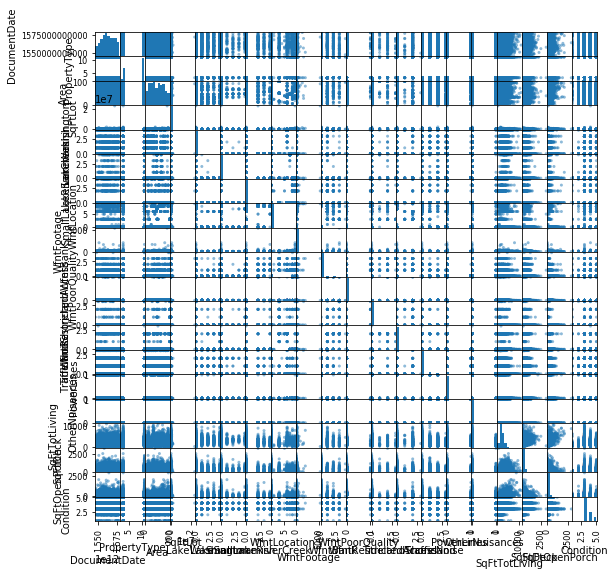

In [53]:
#we can look to see if any scatter plots reveal linear relationships, thus being highly correlated.
#you can see that because we are dealing with a high number of predictors, it's hard to analyze

pd.plotting.scatter_matrix(df_pred, figsize = [9,9]);
plt.show()

In [54]:
#we can also look at the correlation matrix to check this out
#high correlation can generally be assumed with an absolute value of 0.7-0.8 or higher

df_pred.corr()

,DocumentDate,PropertyType,Area,SqFtLot,LakeWashington,LakeSammamish,SmallLakeRiverCreek,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,TidelandShoreland,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
DocumentDate,1.000000,-0.180683,-0.014539,0.010500,0.001370,0.004349,-0.003355,-0.000243,0.005998,-0.003209,0.005124,-0.002795,-0.001799,-0.001284,-0.003635,0.008502,0.002973,-0.004144,0.001581,-0.016570
PropertyType,-0.180683,1.000000,-0.000811,-0.014193,0.002294,0.002617,-0.006931,-0.009575,-0.015996,-0.014035,-0.001468,-0.010279,-0.010200,-0.011407,0.010054,-0.003980,-0.018166,0.022586,-0.028932,0.073331
Area,-0.014539,-0.000811,1.000000,0.048688,-0.056617,0.008902,0.018965,0.036841,0.026620,0.045327,0.008409,0.035747,0.016485,-0.065572,0.053842,-0.041363,0.105163,-0.015526,0.120239,-0.022036
SqFtLot,0.010500,-0.014193,0.048688,1.000000,-0.003101,0.001031,0.051417,0.082785,0.786419,0.106566,0.007512,0.012858,0.003625,0.020745,0.023249,-0.001809,0.034830,0.029570,0.046943,0.006436
LakeWashington,0.001370,0.002294,-0.056617,-0.003101,1.000000,-0.003969,-0.013326,0.243635,0.062214,0.198892,0.009940,0.019860,0.413466,0.034874,-0.008327,-0.011170,0.170149,0.149312,0.066991,0.019143
LakeSammamish,0.004349,0.002617,0.008902,0.001031,-0.003969,1.000000,-0.006161,0.208296,0.050391,0.134568,-0.001827,0.057371,-0.006318,0.009920,-0.007160,-0.006876,0.091645,0.086922,0.036210,-0.004029
SmallLakeRiverCreek,-0.003355,-0.006931,0.018965,0.051417,-0.013326,-0.006161,1.000000,0.604497,0.195383,0.440947,0.132425,0.103784,0.043954,0.004466,-0.002645,0.015552,0.020788,0.081403,0.036348,0.006006
WfntLocation,-0.000243,-0.009575,0.036841,0.082785,0.243635,0.208296,0.604497,1.000000,0.383299,0.808489,0.226503,0.303064,0.474540,-0.000298,-0.009667,0.007378,0.085225,0.129165,0.078568,0.014796
WfntFootage,0.005998,-0.015996,0.026620,0.786419,0.062214,0.050391,0.195383,0.383299,1.000000,0.390703,0.085995,0.164504,0.161448,0.018720,-0.003390,0.000808,0.029502,0.039544,0.034453,0.007994
WfntBank,-0.003209,-0.014035,0.045327,0.106566,0.198892,0.134568,0.440947,0.808489,0.390703,1.000000,0.211773,0.604158,0.638245,-0.004842,-0.008897,0.013424,0.065154,0.135625,0.055623,0.009397


In [56]:
#high correlation can generally be assumed with an absolute value of 0.7-0.8 or higher

abs(df_pred.corr()) > 0.70

,DocumentDate,PropertyType,Area,SqFtLot,LakeWashington,LakeSammamish,SmallLakeRiverCreek,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,TidelandShoreland,TrafficNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition
DocumentDate,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
PropertyType,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Area,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
SqFtLot,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
LakeWashington,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
LakeSammamish,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
SmallLakeRiverCreek,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
WfntLocation,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
WfntFootage,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
WfntBank,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False


In [57]:
df_corr = df_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

df_corr.set_index(['pairs'], inplace=True)

df_corr.drop(columns=['level_1', 'level_0'], inplace=True)

df_corr.columns = ['cc']

df_corr.drop_duplicates(inplace=True)

In [59]:
df_corr[(df_corr.cc > .70) & (df_corr.cc < 1)]

,cc
pairs,
"(WfntBank, WfntLocation)",0.808489
"(WfntFootage, SqFtLot)",0.786419


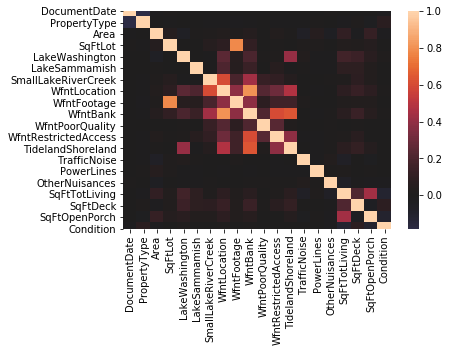

In [62]:
#typically, when you have many variables that are highly correlated with each other, we would want to remove all
#but one of them to remove collinear features

#we can also check the correlations out using a heat map

sns.heatmap(df_pred.corr(), center = 0);

In [78]:
outcome = 'SalePrice'
x_cols = ['LakeWashington', 'LakeSammamish', 'WfntFootage', 
          'WfntLocation', 'SmallLakeRiverCreek']
predictors = '+'.join(x_cols)

model = ols(outcome + '~' + predictors, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     691.5
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:56:05   Log-Likelihood:            -4.0399e+05
No. Observations:               26955   AIC:                         8.080e+05
Df Residuals:                   26949   BIC:                         8.080e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7.661e+05   4844.130    158.156      0.000    7.57e+05    7.76e+05
LakeWashington       5.456e+05   1.25e+04     43.523      0.000    5.21e+05     5.7e+05
LakeSammamish        3.285e+05   2.41e+04     13.634      0.000    2.81e+05    3.76e+05
WfntFootage           318.2060    126.072      2.524      0.012      71.098     565.314
WfntLocation         1.258e+05   7741.050     16.247      0.000    1.11e+05    1.41e+05
SmallLakeRiverCreek -1.848e+05   2.31e+04     -8.000      0.000    -2.3e+05    -1.4e+05
==============================================================================
Omnibus:                    46837.663   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         91667274.002
Skew:                          12.023   Prob(JB):                         0.00
Kurtosis:                     287.675   Cond. No.                         227.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

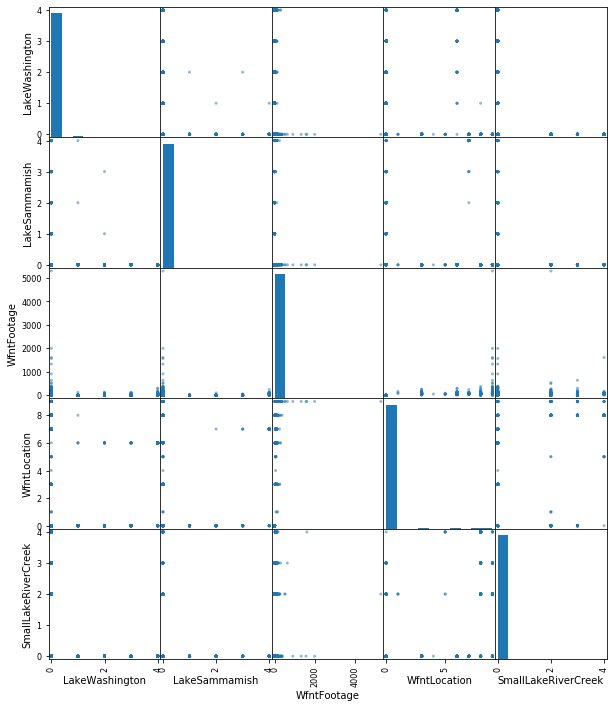

In [79]:
#how are we 

pd.plotting.scatter_matrix(df[x_cols], figsize=(10,12));